<a href="https://colab.research.google.com/github/SamanvayMS/FIN-554-Algo-trading-finalproject/blob/main/VWAP_hypothesis_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install update pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
yf.pdr_override()

In [5]:
start='2000-01-01'
end='2010-01-01'
df = yf.download('SPY',start,end)

[*********************100%***********************]  1 of 1 completed


In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
tech_stocks=['AAPL','MSFT','NVDA','V','MA','CSCO','ACN','CRM','ADBE','AMD']

In [7]:
def data_prep_VWAP(symbol,lookback,start,end):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  df['PV'] = df['Close'] * df['Volume']
  df['CumulativePV'] = df['PV'].rolling(lookback).sum()

  # Calculate the cumulative sum of volume
  df['CumulativeVolume'] = df['Volume'].rolling(lookback).sum()

  # Calculate the rolling VWAP
  df['RollingVWAP'] = df['CumulativePV'] / df['CumulativeVolume']
  df['signal']=np.where(df['Open']>df['RollingVWAP'].shift(1),1,0)
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df['shifted_returns']=df['returns'].shift(-1)
  df['direction'] = [1 if x>0 else 0 for x in df['returns']]
  df=df.dropna(axis=0)
  return df

# Hypothesis Tests 


chi_squared test

In [8]:
from scipy.stats import chi2_contingency

H0 :- null hypothesis assumes no significant relationship between opening price and the previous rolling VWAP value

H1 :- significant relationship with the previous VWAP value bullish when above VWAP and bearish when below VWAP

In [9]:
def chi_2(Symbol,start,end):
  df = data_prep_VWAP(Symbol,lookback=22,start=start,end=end)
  observed=pd.crosstab(df['direction'],df['signal'])
  result = chi2_contingency(observed)
  print(f"p value for {Symbol} is {result[1]}")
  if result[1]>0.01:
    print("null hypothesis cannot be rejected")
  else:
    print("null hypothesis is rejected")

In [10]:
stocks=['SPY','AAPL','MSFT','GOOG','AMZN','JPM','JNJ','CSCO','NKE','DIS']
for stock in stocks:
  chi_2(stock,start,end)

[*********************100%***********************]  1 of 1 completed
p value for SPY is 0.8831203192190378
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed
p value for AAPL is 0.5138359538518882
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed
p value for MSFT is 0.025630048985128294
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed
p value for GOOG is 0.5220185240058981
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed
p value for AMZN is 0.7900193952763703
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed
p value for JPM is 0.6846315675708875
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed
p value for JNJ is 0.48938170126414116
null hypothesis cannot be rejected

wilcox rank test

In [11]:
from scipy.stats import ranksums
from scipy.stats import shapiro
from scipy.stats import ttest_ind

H0:-There is no significant relationship between the returns and the price's position relative to the VWAP.

H1:-The returns are significantly positive when the price is above the VWAP and significantly negative when the price is below the VWAP.

In [12]:
def tests(Symbol,start,end):
  df = data_prep_VWAP(Symbol,lookback=22,start=start,end=end)
  above_vwap = df[df['Open'] > df['RollingVWAP'].shift(1)]['returns']
  below_vwap = df[df['Open'] < df['RollingVWAP'].shift(1)]['returns']

  plt.hist(above_vwap,bins=30,color="green",alpha=0.5)
  plt.hist(below_vwap,bins=30,color="red",alpha=0.5)
  plt.show()
  _, p_value1 = shapiro(above_vwap)
  _, p_value2 = shapiro(below_vwap)
  if p_value1 > 0.01 and p_value2 > 0.01:
    print("returns are normally distributed")
    print("we can run a t-test")
    stat, p_value = ttest_ind(above_vwap, below_vwap, equal_var=True)
  else:
    print("returns are not normally distributed")
    print("we can run a Wilcox Rank Sum test")    
    stat, p_value = ranksums(above_vwap, below_vwap)
  print(f"p value for {Symbol} is {p_value}")
  if p_value>0.01:
    print("null hypothesis cannot be rejected")
  else:
    print("null hypothesis is rejected")

[*********************100%***********************]  1 of 1 completed


returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for SPY is 0.9342154723716692
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


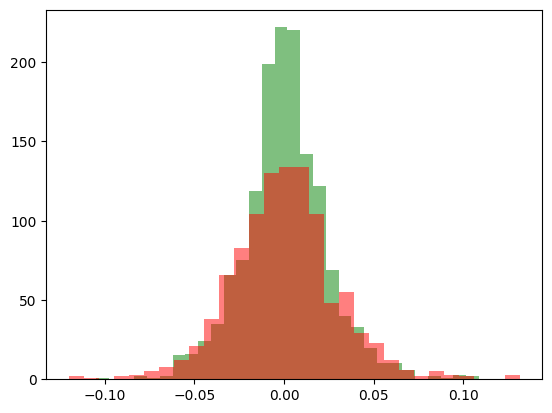

returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for AAPL is 0.42120802228683074
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for MSFT is 0.049846146606800874
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


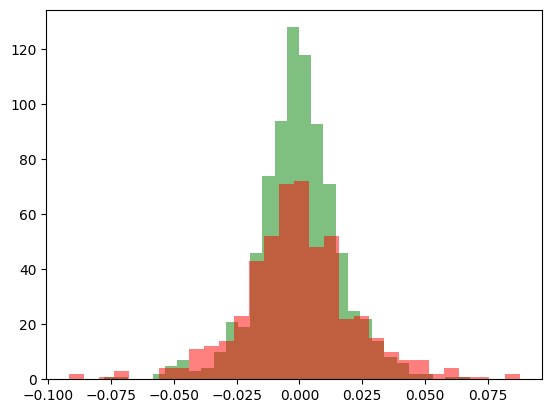

returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for GOOG is 0.433778040754765
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


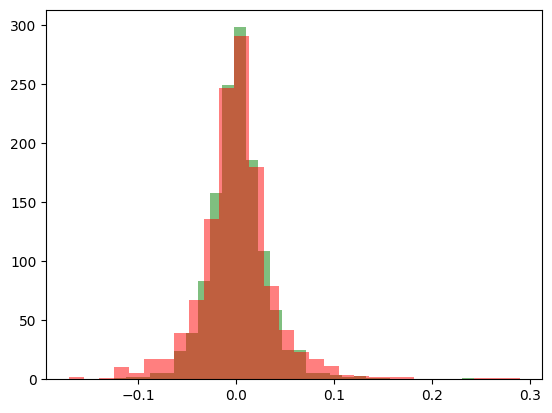

returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for AMZN is 0.6044021885366164
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for JPM is 0.7086203817902481
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


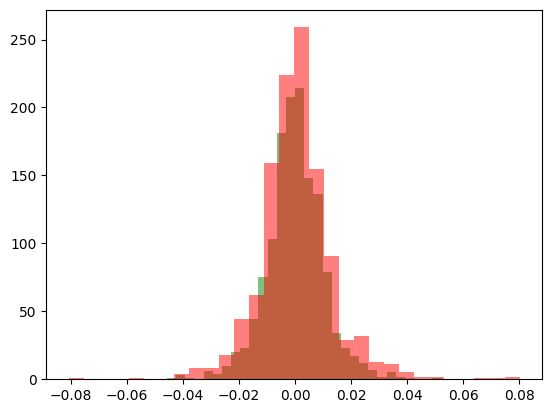

returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for JNJ is 0.5026168329255889
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


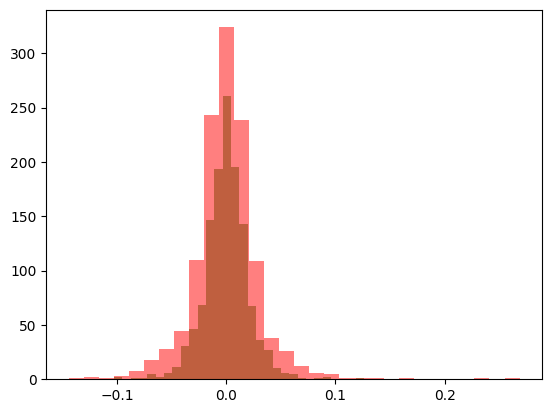

returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for CSCO is 0.6659673092583126
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for NKE is 0.4373215529506336
null hypothesis cannot be rejected
[*********************100%***********************]  1 of 1 completed


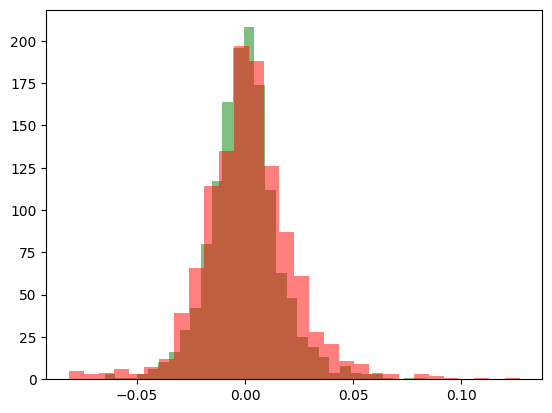

returns are not normally distributed
we can run a Wilcox Rank Sum test
p value for DIS is 0.025824688836200423
null hypothesis cannot be rejected


In [13]:
stocks=['SPY','AAPL','MSFT','GOOG','AMZN','JPM','JNJ','CSCO','NKE','DIS']
for stock in stocks:
  tests(stock,start,end)

# Taking moving averages


In [14]:
def data_prep_EMA(symbol,start,end,ma_list,ema_list):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  # Calculate the rolling MAs
  for ma in ma_list:
    name=str(ma)+'_MA'
    df[name]=df['Close'].rolling(window=ma).mean()
  for ema in ema_list:
    name=str(ema)+'_EMA'
    df[name]=df['Close'].ewm(span=5, adjust=False).mean()
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df=df.dropna(axis=0)
  return df

In [15]:
data_prep_EMA('AAPL',start,end,[100],[100])

[*********************100%***********************]  1 of 1 completed


Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2000-05-24  0.769531  0.801339  0.741071  0.782924   0.666361  678462400   
2000-05-25  0.790179  0.827288  0.767857  0.779157   0.663155  406750400   
2000-05-26  0.785714  0.802455  0.761161  0.771205   0.656387  181148800   
2000-05-30  0.782366  0.786830  0.729911  0.781808   0.665411  713059200   
2000-05-31  0.775670  0.814732  0.748326  0.750000   0.638339  433507200   
...              ...       ...       ...       ...        ...        ...   
2009-12-24  7.269643  7.476786  7.262500  7.465714   6.354207  500889200   
2009-12-28  7.561429  7.641071  7.486071  7.557500   6.432326  644565600   
2009-12-29  7.593929  7.597143  7.454643  7.467857   6.356029  445205600   
2009-12-30  7.458214  7.571429  7.439643  7.558571   6.433239  412084400   
2009-12-31  7.611786  7.619643  7.520000  7.526071   6.405577  352410800   

              100_MA   100_EMA   returns  
Date                                      
2000-05-24  1.023852  0.814300  0.017404  
2000-05-25  1.021649  0.802586 -0.013949  
2000-05-26  1.020209  0.792126 -0.018466  
2000-05-30  1.018742  0.788686 -0.000713  
2000-05-31  1.017759  0.775791 -0.033094  
...              ...       ...       ...  
2009-12-24  6.670014  7.223913  0.026971  
2009-12-28  6.686621  7.335109 -0.000520  
2009-12-29  6.702761  7.379358 -0.016602  
2009-12-30  6.719236  7.439096  0.013456  
2009-12-31  6.735668  7.468087 -0.011261  

[2416 rows x 9 columns]

In [16]:
def tests_MA(Symbol,start,end,ma_list,ema_list):
  df = data_prep_EMA(Symbol,start,end,ma_list,ema_list)
  for ma in ma_list:
    column=str(ma)+'_MA'
    above_ma = df[df['Open'] > df[column].shift(1)]['returns']
    below_ma = df[df['Open'] < df[column].shift(1)]['returns']

    plt.hist(above_ma,bins=30,color="green",alpha=0.5)
    plt.hist(below_ma,bins=30,color="red",alpha=0.5)
    plt.show()
    _, p_value1 = shapiro(above_ma)
    _, p_value2 = shapiro(below_ma)
    if p_value1 > 0.01 and p_value2 > 0.01:
      print("returns are normally distributed")
      print("we can run a t-test")
      stat, p_value = ttest_ind(above_ma, below_ma, equal_var=True)
    else:
      print("returns are not normally distributed")
      print("we can run a Wilcox Rank Sum test")    
      stat, p_value = ranksums(above_ma, below_ma)
    print(f"p value for {Symbol} is {p_value}")
    if p_value>0.01:
      print(f"null hypothesis cannot be rejected for {Symbol} taking ma{ma}")
    else:
      print(f"null hypothesis is rejected for {Symbol} taking ma{ma}")
  for ema in ema_list:
    column=str(ma)+'_EMA'
    above_ema = df[df['Open'] > df[column].shift(1)]['returns']
    below_ema = df[df['Open'] < df[column].shift(1)]['returns']

    plt.hist(above_ema,bins=30,color="green",alpha=0.5)
    plt.hist(below_ema,bins=30,color="red",alpha=0.5)
    plt.show()
    _, p_value1 = shapiro(above_ema)
    _, p_value2 = shapiro(below_ema)
    if p_value1 > 0.01 and p_value2 > 0.01:
      print("returns are normally distributed")
      print("we can run a t-test")
      stat, p_value = ttest_ind(above_ema, below_ema, equal_var=True)
    else:
      print("returns are not normally distributed")
      print("we can run a Wilcox Rank Sum test")    
      stat, p_value = ranksums(above_ema, below_ema)
    print(f"p value for {Symbol} is {p_value}")
    if p_value>0.01:
      print(f"null hypothesis cannot be rejected for {Symbol} taking ema{ema}")
    else:
      print(f"null hypothesis is rejected for {Symbol} taking ema{ema}")

In [ ]:
ema_list=[9,20,50,100,200]
ma_list=[9,20,50,100,200]
stocks=['SPY','AAPL','MSFT','GOOG','AMZN','JPM','JNJ','CSCO','NKE','DIS']
for stock in stocks:
  tests_MA(stock,start,end,ma_list,ema_list)

Instead of checking for daily returns we are going to check for cummulative returns.
we can do this by testing the strategy compared to that of a benchmark strategy sucha s a buy and hold. 
we test the hypothesis that the cummulative returns generated by the VWAP strategy are not different from that generated by a single trade with the vwap strategy 

Use one tailed paired t-test for confirming this hypothesis

In [18]:
def data_prep_VWAP2(symbol,lookback,start,end):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  df['PV'] = df['Close'] * df['Volume']
  df['CumulativePV'] = df['PV'].rolling(lookback).sum()

  # Calculate the cumulative sum of volume
  df['CumulativeVolume'] = df['Volume'].rolling(lookback).sum()

  # Calculate the rolling VWAP
  df['RollingVWAP'] = df['CumulativePV'] / df['CumulativeVolume']
  df['returns']=(df['Close']-df['Close'].shift(1))/df['Close'].shift(1)
  df["day's return"]=(df['Close']-df['Open'])/df['Open']
  df=df.dropna(axis=0)
  return df

In [19]:
data_prep_VWAP2('AAPL',22,start,end)

[*********************100%***********************]  1 of 1 completed


Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2000-02-02  0.899554  0.911830  0.866071  0.882254   0.750903  464195200   
2000-02-03  0.895647  0.930804  0.895089  0.922433   0.785100  475193600   
2000-02-04  0.928013  0.982143  0.925223  0.964286   0.820721  425320000   
2000-02-07  0.964286  1.020089  0.945871  1.018415   0.866792  441067200   
2000-02-08  1.017857  1.036830  0.993304  1.025670   0.872967  408643200   
...              ...       ...       ...       ...        ...        ...   
2009-12-24  7.269643  7.476786  7.262500  7.465714   6.354207  500889200   
2009-12-28  7.561429  7.641071  7.486071  7.557500   6.432327  644565600   
2009-12-29  7.593929  7.597143  7.454643  7.467857   6.356029  445205600   
2009-12-30  7.458214  7.571429  7.439643  7.558571   6.433239  412084400   
2009-12-31  7.611786  7.619643  7.520000  7.526071   6.405577  352410800   

                      PV  CumulativePV  CumulativeVolume  RollingVWAP  \
Date                                                                    
2000-02-02  4.095381e+08  1.227971e+10      1.333741e+10     0.920697   
2000-02-03  4.383343e+08  1.218254e+10      1.327680e+10     0.917581   
2000-02-04  4.101301e+08  1.212376e+10      1.318975e+10     0.919180   
2000-02-07  4.491894e+08  1.185022e+10      1.285249e+10     0.922017   
2000-02-08  4.191331e+08  1.161795e+10      1.249316e+10     0.929944   
...                  ...           ...               ...          ...   
2009-12-24  3.739496e+09  7.631050e+10      1.086470e+10     7.023710   
2009-12-28  4.871304e+09  7.885675e+10      1.119083e+10     7.046553   
2009-12-29  3.324732e+09  8.009252e+10      1.134958e+10     7.056871   
2009-12-30  3.114769e+09  8.109209e+10      1.146641e+10     7.072145   
2009-12-31  2.652269e+09  8.071102e+10      1.139396e+10     7.083668   

             returns  day's return  
Date                                
2000-02-02 -0.014339     -0.019232  
2000-02-03  0.045541      0.029907  
2000-02-04  0.045372      0.039087  
2000-02-07  0.056134      0.056134  
2000-02-08  0.007124      0.007676  
...              ...           ...  
2009-12-24  0.034339      0.026971  
2009-12-28  0.012294     -0.000520  
2009-12-29 -0.011861     -0.016602  
2009-12-30  0.012147      0.013456  
2009-12-31 -0.004300     -0.011261  

[2494 rows x 12 columns]

Trade Entry :- we wait for close to cross above VWAP and then enter at next days Open
Exit :- Once the Close is  below the VWAP we exit the position and take a short on the next days open (Ignoring Slippage)

In [20]:
def VWAP_crossover(symbol,lookback,start,end):
  df = data_prep_VWAP2(symbol,lookback,start,end) # prepares the dataset
  df['strat_returns']=np.zeros(len(df)) # initialise the strategy column
  long_trade=False # sets long and short trade indicator to false 
  short_trade=False
  for date in df.index:
    if long_trade: 
      if just_entered:
        #print('entered long trade',df.loc[date]["day's return"])
        df.loc[date,'strat_returns'] = df.loc[date,"day's return"]
        just_entered=False
      else:        
        #print('in long trade',df.loc[date]['returns'])
        df.loc[date,'strat_returns'] = df.loc[date,'returns']
    elif short_trade:
      if just_entered:
        #print('entered short trade',-df.loc[date]["day's return"])
        df.loc[date,'strat_returns'] = -df.loc[date,"day's return"]
        just_entered=False
      else:      
        #print('in short trade',-df.loc[date]['returns'])
        df.loc[date,'strat_returns'] = -df.loc[date,'returns']
    else:
      df.loc[date,'strat_returns'] = 0
    if df.loc[date,'Close'] > df.loc[date,'RollingVWAP']:
      if long_trade==False:
        just_entered=True
      long_trade=True
      short_trade=False
    else:
      if short_trade==False:
        just_entered=True
      long_trade=False
      short_trade=True
  return df

In [21]:
start='2010-01-01'
end='2015-01-01'
aapl=VWAP_crossover('AAPL',200,start,end)

[*********************100%***********************]  1 of 1 completed


<ipython-input-20-83758389f7ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['strat_returns']=np.zeros(len(df)) # initialise the strategy column


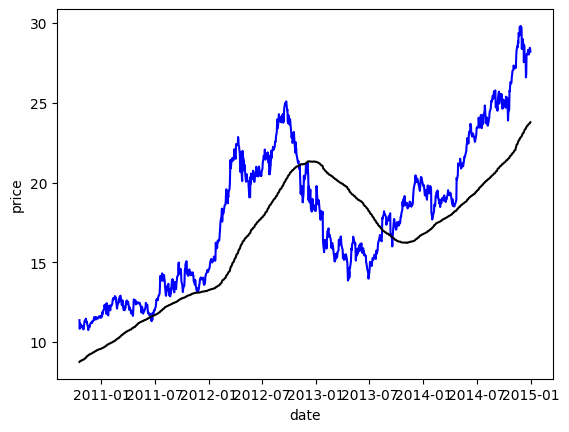

In [22]:
plt.plot(aapl['Open'],c='blue')
plt.plot(aapl['RollingVWAP'],c='black')
plt.xlabel('date')
plt.ylabel('price')
plt.show()

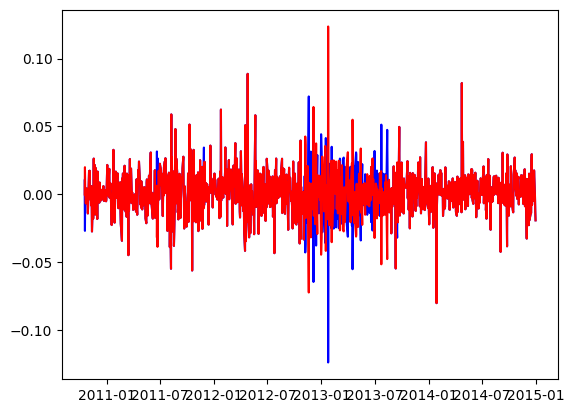

In [23]:
plt.plot(aapl['returns'],c='blue')
plt.plot(aapl['strat_returns'],c='red')
plt.show()

In [24]:
def ret(returns):
  return (returns+1).cumprod()

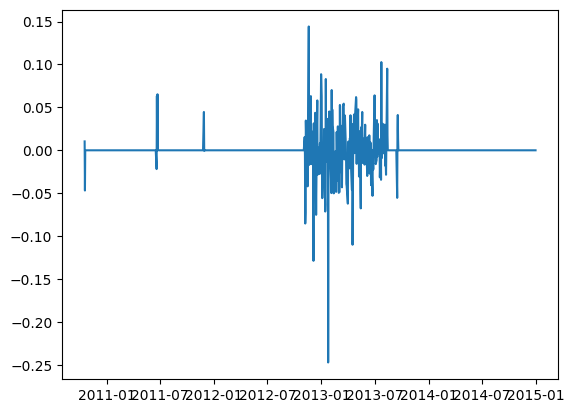

In [25]:
plt.plot(aapl['returns']-aapl['strat_returns'])

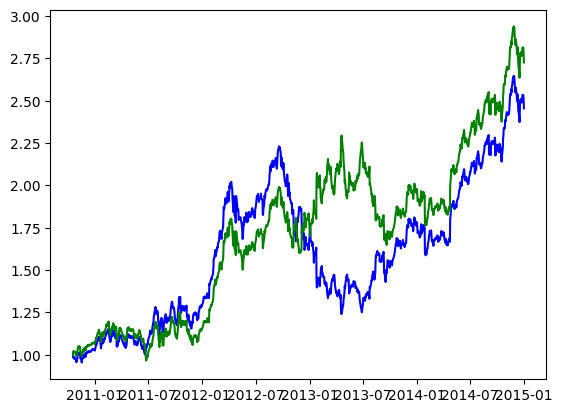

In [26]:
plt.plot(ret(aapl['returns']),c='blue')
plt.plot(ret(aapl['strat_returns']),c='green')
plt.show()

upon close examination we see lot of errors with our entry instead we added a slight modification in order to confirm our entries where we look at both previous days close and current days open to take our entries. 

In [27]:
def plots(df):
  if isinstance(df, pd.DataFrame):
    """
    Calculates the drawdowns given a column of daily returns.
    Returns a pandas DataFrame with columns for daily returns,
    cumulative returns, and drawdowns.
    """
    # Calculate cumulative returns
    cum_returns = (1 + df.returns).cumprod()
    cum_returns_strat = (1 + df.strat_returns).cumprod()
    # Calculate the previous peaks
    previous_peaks = cum_returns.cummax()
    previous_peaks_strat = cum_returns_strat.cummax()

    # Calculate the drawdowns
    drawdowns = (cum_returns - previous_peaks) / previous_peaks
    drawdowns_strat = (cum_returns_strat - previous_peaks_strat) / previous_peaks_strat
    # Create a DataFrame with the results
    results = pd.DataFrame({'Cumulative Returns': cum_returns,
                            'Strategy Cumulative Returns': cum_returns_strat,
                            'Drawdowns': drawdowns,
                            'Strategy Drawdowns': drawdowns_strat})
    
    fig,axs = plt.subplots(3,figsize=(10,15))
    axs[0].plot(results.iloc[:,:2],label=results.columns[:2])
    axs[0].set_title('cummulative returns')
    axs[0].set_ylabel('Returns')
    axs[0].set_xlabel('date')
    axs[1].plot(results.iloc[:,2:],label=results.columns[2:])
    axs[1].set_title('drawdown')
    axs[1].set_ylabel('drawdown')
    axs[1].set_xlabel('date')
    axs[2].hist(aapl.returns,alpha=0.5,bins=30,label='benchmark')
    axs[2].hist(aapl.strat_returns,alpha=0.5,bins=30,label='strategy')
    axs[2].set_title('distribution of returns')
    axs[2].set_xlabel('returns')
    axs[2].set_ylabel('frequency')
    fig.legend()
    fig.show()
    return results
  else:
    print('invalid datatype')
    return None



In [ ]:
plots(aapl)

In [29]:
# strategy hypothesis tests

In [30]:
from scipy.stats import ttest_rel

In [31]:
def strat_1tailed_test(df):
  group1=df.returns
  group2=df.strat_returns
  t_stat, p_value = ttest_rel(group1, group2, alternative='greater')

  print('mean_returns of benchmark = ',np.mean(group1))
  print('mean_returns of strategy = ',np.mean(group2))
  if p_value>0.01:
    print(f"null hypothesis cannot be rejected for this strategy")
  else:
    print(f"null hypothesis is rejected for this strategy")
  return p_value

In [32]:
strat_1tailed_test(aapl)

mean_returns of benchmark =  0.000985274649951406
mean_returns of strategy =  0.0010821382445507749
null hypothesis cannot be rejected for this strategy


0.568832282967152

In [ ]:
lookbacks=[20,50,100,200]
start='2000-01-01'
end='2015-01-01'
tech_stocks_hypothesis_rejected={}
for stock in tech_stocks:
  for lookback in lookbacks:
    df=VWAP_crossover(stock,lookback,start,end)
    drawdowns=plots(df)
    p_value = strat_1tailed_test(df)
    if p_value<0.01:
      tech_stocks_hypothesis_rejected[stock+str(lookback)]=p_value




In [34]:
hypothesis_rejected

{'JNJ50': 0.006300995206054723,
 'NKE50': 0.0063239573916689515,
 'NKE100': 0.005642345839484868,
 'NKE200': 0.008935555685220439}

In [ ]:
['AAPL','MSFT','NVDA','V','MA','CSCO','ACN','CRM','ADBE','AMD']

In [ ]:
df=VWAP_crossover('NKE',50,start,end)
drawdowns=plots(df)